In [1]:
from grand import topography
from grand.tools.topography import Topography, Reference

from grand.tools import ECEF, Geodetic, LTP, GRAND, CartesianRepresentation
import numpy as np

In [2]:
# Points delimiting GP300 array
latitude = np.array([41.4484450740, 41.3240186504, 41.2682974353, 41.2699858577, 41.3599099238, 41.4116665473,41.4484450740])
longitude= np.array([96.6878480765, 96.6703102286, 96.5824288586, 96.5302861717, 96.4543304128, 96.5113155088,96.6878480765])
height   = np.zeros(len(latitude))
subeiAllg  = Geodetic(latitude=latitude, longitude=longitude, height=height)
subeiDg    = Geodetic(latitude=41.2699858577, longitude=96.5302861717, height=0) # This oen is used as teh erference of GRAND ref


# GP300 layout to GRAND coordinates
subeiAllG  = GRAND(subeiAllg, location=subeiDg) 

# update data
topography.update_data(coordinates=subeiDg, radius=1e4) # radius in meter

In [3]:
# Change datadir based on your grand location.
#datadir = '/Users/rameshkoirala/Documents/GRAND/grand/grand/tools/data/topography'
#datadir = '/home/olivier/GRAND/soft/grand/grand/tools/data/topography/'
datadir = '../grand/grand/tools/data/topography/'
topo = Topography(datadir)
elev1 = topo.elevation(subeiDg) # method 1
elev2= topography.elevation(subeiDg, Reference.ELLIPSOID) # elevation wrt ellipsoid (method 2)
elev2b= topography.elevation(subeiDg, Reference.GEOID)     # elevation wrt geoid (method 2)
print('Elevation based on GRAND coordinate system.')
print('    elevation method1  :', elev1)
print('    elevation method2  :', elev2) 
print('    elevation w.r.t geoid:',elev2b)

undu = topography.geoid_undulation(subeiDg)        # geoid (ie sea level) undulation (departure from ellispoid)
print('    undulation         :', undu) 

# elevation based on LTP and GRAND coordinate system.
ltp  = LTP(x=0, y=0, z=0, location=subeiDg, magnetic=True, orientation='NWU') # Create GRAND ref by hand
gcs1 = GRAND(x=0, y=0, z=0, location=subeiDg)     # z-coordinate does not matter. elevation wrt to XY-plane at (x,y).
print('Elevation based on GRAND coordinate system.')
print('    elevation LTP    :', topography.elevation(ltp))
print('    elevation GRAND ref :', topography.elevation(gcs1))


Elevation based on GRAND coordinate system.
    elevation method1  : 2013.9643291656948
    elevation method2  : 2013.9643291656948
    elevation w.r.t geoid: 2025.9777673666085
    undulation         : -12.013438200913718
Elevation based on GRAND coordinate system.
    elevation LTP    : 2013.9643291658458
    elevation GRAND ref : 2013.9643291658458


In [4]:
# Get the local ground elevation over a grid and plot it.

# Build a meshgrid for ground topography
distm = 29000
xmin = -distm
xmax = +distm
ymin = -distm
ymax = +distm
nsteps = 401 # nb of topo steps
x = np.linspace(xmin, xmax, nsteps) 
y = np.linspace(ymin, ymax, nsteps)
X, Y = np.meshgrid(x, y)
ground_grid = GRAND(x=X.flatten(), y=Y.flatten(), z=np.zeros(X.size),location=subeiDg)  
zg = topography.elevation(ground_grid) # Fetch elevation data 
### WARNING 
# As ground_grid is in GRAND ref, topography.elevation corresponds to z value of coordinate in GRAND ref 
# and not altitude asl. This means that Earth curvature is not corrected for here.
ground_grid[2] =  zg # Update altitudes
zg = zg.reshape(X.shape) # Format as matrix

# Now go to Geodetic coordinates
ground_grid_geo = Geodetic(ground_grid)
# Now reformat output
lat = ground_grid_geo.latitude.reshape(X.shape) # Format as matrix
lat = lat[0] # Grab first line
lon = ground_grid_geo.longitude.reshape(X.shape) # Format as matrix
lon = lon[:,0] #Grab first col
zg_geo = ground_grid_geo.height # This is altitude (wrt ellispoid as default)
zg_geo = zg_geo.reshape(X.shape) # Format as matrix

deltaz = zg_geo - zg;  # Difference between geodetic height and z_GRAND (= Earth curvature)

/var/folders/bd/cs_gv8611mz55v2v0wmbcf4w0000gn/T/ipykernel_23004/473733155.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolor(x,y,zg, cmap='terrain', alpha=0.75)
/var/folders/bd/cs_gv8611mz55v2v0wmbcf4w0000gn/T/ipykernel_23004/473733155.py:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolor(-y,x,zg.T, cmap='terrain', alpha=0.75)
/var/folders/bd/cs_gv8611mz55v2v0wmbcf4w0000gn/T/ipykernel_23004/473733155.py:27: MatplotlibDeprecationWarning: 

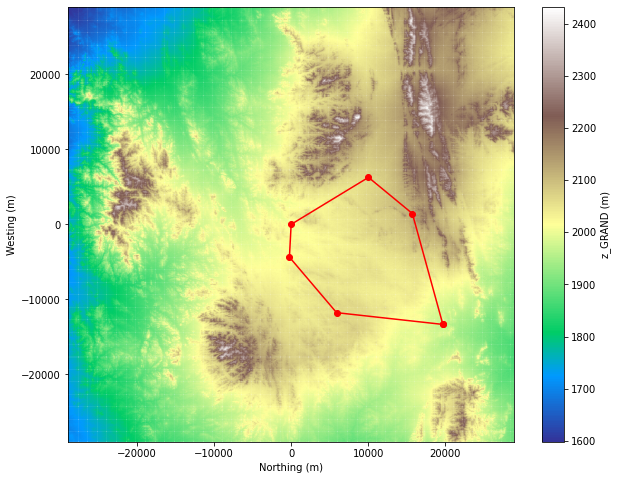

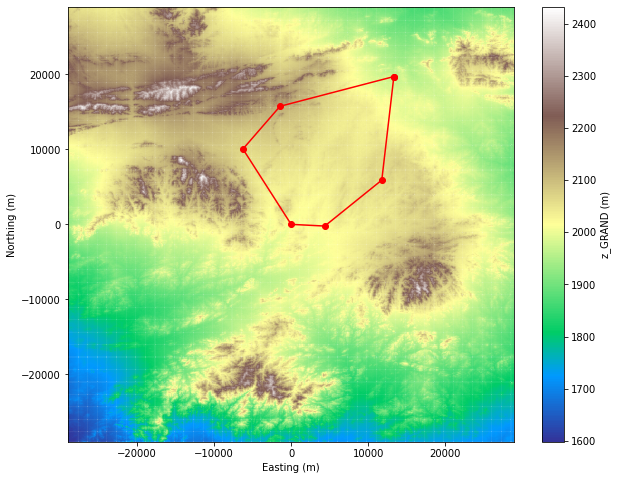

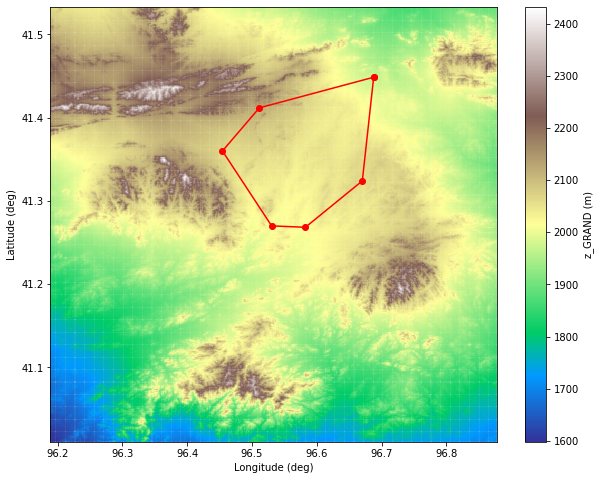

In [10]:
# Now plot the terrain
from matplotlib import cm, colors, pyplot as pl
from matplotlib.ticker import LinearLocator, FormatStrFormatter
norm = colors.Normalize(vmin=np.amin(zg), vmax=np.amax(zg))
m = cm.ScalarMappable(cmap='terrain',norm=norm)

# Topography plot x = North, y = West
pl.figure(figsize=(10,8))
pl.pcolor(x,y,zg, cmap='terrain', alpha=0.75)
pl.plot(subeiAllG.x,subeiAllG.y,'or-')
pl.xlabel('Northing (m)')
pl.ylabel('Westing (m)')
bar = pl.colorbar(m)
bar.set_label('z_GRAND (m)')

# Topography plot x = East, y = North (standard)
pl.figure(figsize=(10,8))
pl.pcolor(-y,x,zg.T, cmap='terrain', alpha=0.75)
pl.plot(-subeiAllG.y,subeiAllG.x,'or-')
pl.xlabel('Easting (m)')
pl.ylabel('Northing (m)')
bar = pl.colorbar(m)
bar.set_label('z_GRAND (m)')

# Plot in Goedetic coordinates (z = GRAND height)
pl.figure(figsize=(10,8))
pl.pcolor(lon,lat,zg.T, cmap='terrain', alpha=0.75)
pl.plot(subeiAllg.longitude,subeiAllg.latitude,'or-')
pl.xlabel('Longitude (deg)')
pl.ylabel('Latitude (deg)')
bar = pl.colorbar(m)
bar.set_label('z_GRAND (m)')

pl.show()

/var/folders/bd/cs_gv8611mz55v2v0wmbcf4w0000gn/T/ipykernel_23004/3735158569.py:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolor(x,y,zg_geo, cmap='terrain', alpha=0.75)
/var/folders/bd/cs_gv8611mz55v2v0wmbcf4w0000gn/T/ipykernel_23004/3735158569.py:19: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolor(x,y,deltaz, cmap='terrain', alpha=0.75)


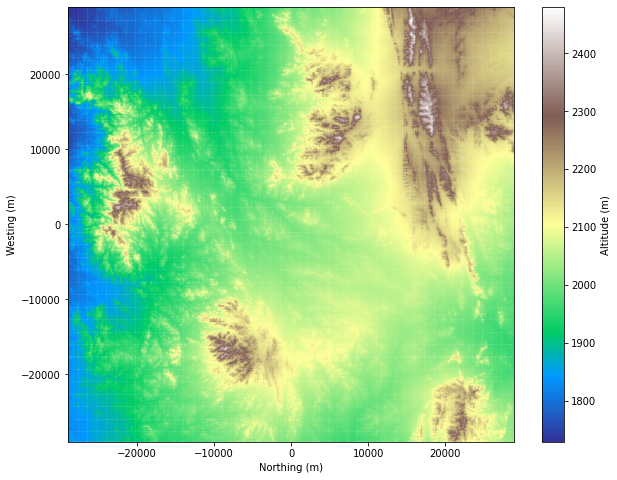

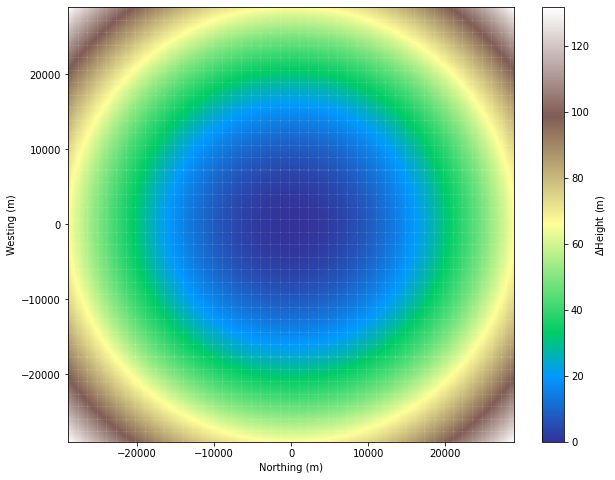

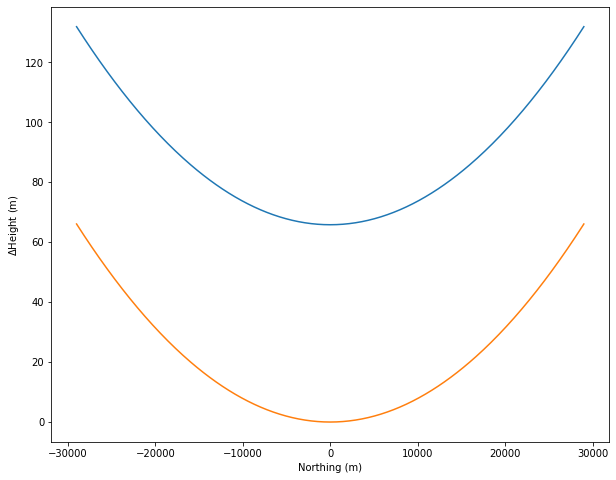

In [11]:
# Just a few tests to better understand the subtilities of topography.elevation 
# for inputs in GRAND OR Geodetic coords.

norm = colors.Normalize(vmin=np.amin(zg_geo), vmax=np.amax(zg_geo))
m = cm.ScalarMappable(cmap='terrain',norm=norm)

# Plot with z = Geodetic z
pl.figure(figsize=(10,8))
pl.pcolor(x,y,zg_geo, cmap='terrain', alpha=0.75)
pl.xlabel('Northing (m)')
pl.ylabel('Westing (m)')
bar = pl.colorbar(m)
bar.set_label('Altitude (m)')

# Difference with GRAND altitudes = Earth curvature
norm = colors.Normalize(vmin=np.amin(deltaz), vmax=np.amax(deltaz))
m = cm.ScalarMappable(cmap='terrain',norm=norm)
pl.figure(figsize=(10,8))
pl.pcolor(x,y,deltaz, cmap='terrain', alpha=0.75)
pl.xlabel('Northing (m)')
pl.ylabel('Westing (m)')
bar = pl.colorbar(m)
bar.set_label('$\Delta$Height (m)')

pl.figure(figsize=(10,8))
pl.plot(x,deltaz[0])
pl.plot(x,deltaz[round(nsteps/2)])
pl.xlabel('Northing (m)')
pl.ylabel('$\Delta$Height (m)')

pl.show()

Distance to ground: 11885.754295999963


/var/folders/bd/cs_gv8611mz55v2v0wmbcf4w0000gn/T/ipykernel_23004/46211710.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  pl.pcolor(x,y,zg, cmap='terrain', alpha=0.75)


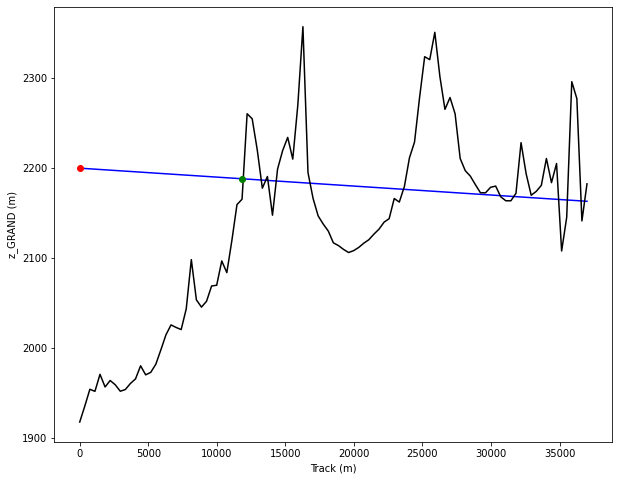

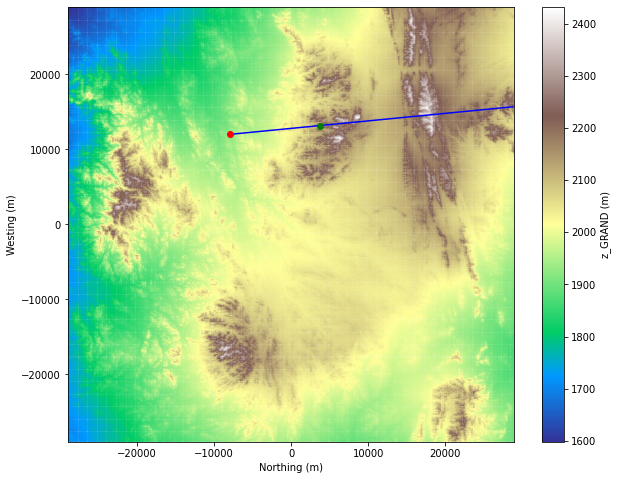

In [9]:
# Now check when a given trajectory meets ground
# Does not match with distance function... To be solved.

dirG = CartesianRepresentation(x=100, y=10, z=-0.1)   # Traj = direction vector in GRAND ref
x0   = GRAND(x=-8000,y=12000,z=2200,location=subeiDg) # Initial point along traj (in GRAND ref)
direction = np.matmul(x0.basis.T, dirG)        # GRAND --> ECEF. input direction must be in ECEF. ToDo: Fix this.
distance1 = topography.distance(x0, direction) # direction vector here is in ECEF frame.
direction = np.matmul(x0.basis, direction)     # change direction vector back to GRAND frame.
print("Distance to ground:",distance1)

#Build traj
u = np.linspace(0,3.7e4,101)  # Distance from x0 (meters)
dirn = direction/np.linalg.norm(direction) # normalize direction vector
traj = dirn * u + x0 

# Get elevation below traj
traj_grand = GRAND(x=traj[0], y=traj[1], z=np.zeros(len(traj[0])),location=subeiDg)  # Compute traj coordinates
ztg = topography.elevation(traj_grand) # z-coordinate of ground in GRAND ref

icrash = np.argmin(abs(u-distance1)) # index of trajectory closest to intersection to ground

# Side view
pl.figure(figsize=(10,8))
pl.plot(u,traj[2],'b') # traj
pl.plot(u,ztg,'k') # ground
pl.plot(0,x0.z,'or') # initial point
pl.plot(u[icrash],traj[2,icrash],'og') #intersection with ground
pl.xlabel('Track (m)')
pl.ylabel('z_GRAND (m)')

# Top view
pl.figure(figsize=(10,8))
norm = colors.Normalize(vmin=np.amin(zg), vmax=np.amax(zg))
m = cm.ScalarMappable(cmap='terrain',norm=norm)
pl.pcolor(x,y,zg, cmap='terrain', alpha=0.75)
pl.plot(traj[0],traj[1],'b')
pl.plot(x0.x,x0.y,'or')
pl.plot(traj[0,icrash],traj[1,icrash],'og') #intersection with ground
pl.xlabel('Northing (m)')
pl.ylabel('Westing (m)')
bar = pl.colorbar(m)
bar.set_label('z_GRAND (m)')

pl.show()